### Model Training and Deployment Details

This section details the machine learning model developed for skin lesion classification, covering its architecture, training methodology, evaluation, and deployment strategies.

#### 1. Dataset Preparation

The project utilizes the **HAM10000 (Human Against Machine with 10000 training images)** dataset, a collection of 10,015 dermatoscopic images of common pigmented skin lesions. The dataset was split into 80% for training and 20% for validation. To manage the dataset efficiently and avoid memory issues during training, images were organized into separate directories for training and validation sets, with subdirectories for each of the seven diagnostic categories:

*   `nv` (Melanocytic nevi)
*   `mel` (Melanoma)
*   `bkl` (Benign keratosis-like lesions)
*   `bcc` (Basal cell carcinoma)
*   `akiec` (Actinic keratoses and intraepithelial carcinoma / Bowen’s disease)
*   `vasc` (Vascular lesions)
*   `df` (Dermatofibroma)

#### 2. Data Augmentation

To enhance the model's generalization capabilities and mitigate overfitting, aggressive data augmentation techniques were applied using `ImageDataGenerator` in TensorFlow Keras. The augmentation parameters were chosen to simulate various real-world imaging conditions and introduce significant variations in the training data:

*   `rotation_range=20`: Random rotations up to 20 degrees.
*   `width_shift_range=0.2`: Random horizontal shifts up to 20% of the image width.
*   `height_shift_range=0.2`: Random vertical shifts up to 20% of the image height.
*   `shear_range=0.2`: Shear-based transformations.
*   `zoom_range=0.2`: Random zooms.
*   `horizontal_flip=True`: Random horizontal flipping.
*   `vertical_flip=True`: Random vertical flipping.
*   `fill_mode='nearest'`: Strategy for filling newly created pixels.

The images were preprocessed using `tf.keras.applications.mobilenet.preprocess_input` to match the input requirements of the MobileNetV2 architecture.

#### 3. Model Architecture: MobileNetV2 with Spatial Transformer Network (STN)

The model is built upon a **MobileNetV2** base, a highly efficient convolutional neural network architecture suitable for mobile and embedded vision applications. The `MobileNetV2` model was loaded with `imagenet` weights to leverage transfer learning and was configured with `alpha=0.75` for a slightly smaller and faster model. Critically, only the top 50 layers of MobileNetV2 were unfrozen, allowing for fine-tuning specific to our dataset while retaining the robust feature extraction capabilities of the pre-trained layers.

To enhance the model's robustness to spatial transformations (e.g., rotation, scaling, translation) inherent in dermatoscopic images, a **Spatial Transformer Network (STN)** was integrated into the architecture. The STN dynamically transforms the input feature maps, allowing the network to actively learn invariance to these transformations. This is particularly beneficial in medical imaging where precise alignment can significantly impact diagnostic accuracy.

The STN component consists of:
*   A localization network (convolutional and pooling layers) that predicts the parameters of the affine transformation.
*   A grid generator that creates a sampling grid based on these parameters.
*   A sampler that warps the input feature map according to the sampling grid.

Following the MobileNetV2 base and the STN layer, the model includes custom classification layers:
*   `GlobalAveragePooling2D`: Reduces the spatial dimensions of the feature maps.
*   `BatchNormalization`: Stabilizes the learning process and improves training speed.
*   `Dropout(0.4)`: Regularization to prevent overfitting.
*   `Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.01))`: The final output layer with 7 units (one for each class) and softmax activation for multi-class probability distribution, with L2 regularization for weight decay.

#### 4. Training Strategy

The model was compiled with the **Adam optimizer** and an initial learning rate of `0.001`. The loss function used was `categorical_crossentropy`, appropriate for multi-class classification. Key metrics monitored during training included `categorical_accuracy` and `tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')`.

To address class imbalance within the HAM10000 dataset, **class weights** were computed and applied during training. This ensures that the model pays more attention to under-represented classes, preventing bias towards dominant classes.

**Callbacks** were crucial for an effective training process:
*   **`ModelCheckpoint`**: Saves the best model weights (`.keras` format) based on `val_top_3_accuracy`, ensuring that the best performing model on unseen data is preserved.
*   **`ReduceLROnPlateau`**: Dynamically reduces the learning rate by a factor of 0.5 when `val_top_3_accuracy` plateaus for 2 epochs, with a `min_lr` of `1e-9` to allow for fine-grained adjustments.
*   **`EarlyStopping`**: Monitors `val_categorical_accuracy` and stops training if it doesn't improve by at least `0.01` for 3 consecutive epochs, restoring the best weights to prevent overfitting.
*   **`TensorBoard`**: Used for visualization of training metrics and graph analysis.

Training was performed for 50 epochs, and the learning rate was initially set to `1e-5` after loading pre-trained weights, indicating a fine-tuning phase after initial training or a continued optimization step.

#### 5. Evaluation

After training, the model's performance was rigorously evaluated on the validation set using:
*   **Classification Report**: Provides precision, recall, f1-score, and support for each class, offering a detailed view of per-class performance.
*   **Confusion Matrix**: Visualizes the performance of an algorithm, showing the counts of true-positive, true-negative, false-positive, and false-negative predictions for each class.

The metrics obtained from these evaluations (e.g., categorical accuracy, top-3 accuracy, and per-class F1-scores) serve as key indicators of the model's diagnostic capability.

#### 6. Model Export and Deployment

To facilitate deployment across various platforms, the trained model was exported in multiple formats:

*   **TensorFlow SavedModel Format**: The model was saved to `/content/drive/My Drive/MODEL_CORRECTION/model_unquant` (and later to `model_unquant_savedmodel`). This universal serialization format allows the model to be used with TensorFlow Serving, TensorFlow Lite, TensorFlow.js, or other programs.

*   **TensorFlow Lite (TFLite)**: The model was converted to `.tflite` format for optimized inference on mobile and embedded devices. This conversion involves quantization and other optimizations to reduce model size and improve latency while maintaining accuracy. The TFLite model was saved to `/content/drive/My Drive/MODEL_CORRECTION/model_unquant.tflite`.

*   **TensorFlow.js**: The model was also converted to a format compatible with TensorFlow.js, enabling deployment directly in web browsers. This allows for client-side inference without needing a backend server, which can significantly improve user experience and reduce server load. The TensorFlow.js model was saved to `/content/drive/My Drive/MODEL_CORRECTION/tfjs_model`.

In [ ]:
#Cell 1: Import Necessary Libraries

import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pickle # Import pickle for saving history

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2: Dataset Setup and Preparation

# Kaggle dataset setup
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d /content/

cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [00:27<00:00, 282MB/s]
100% 5.20G/5.20G [00:27<00:00, 201MB/s]


In [ ]:
#cell 3
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the path to the dataset and load the CSV file
dataset_path = '/content'
csv_file = '/content/HAM10000_metadata.csv'

# Load the CSV file
df = pd.read_csv(csv_file)

# Create directories for training and validation
train_dir = '/content/train'
val_dir = '/content/val'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Create subdirectories for each class in train and val
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)

# Function to move images to the corresponding directories
def move_images(df, dest_dir):
    for _, row in df.iterrows():
        image_id = row['image_id']
        dx = row['dx']
        # Check if the image is in part_1 or part_2
        src_part1 = os.path.join(dataset_path, 'HAM10000_images_part_1', image_id + '.jpg')
        src_part2 = os.path.join(dataset_path, 'HAM10000_images_part_2', image_id + '.jpg')

        if os.path.exists(src_part1):
            src = src_part1
        elif os.path.exists(src_part2):
            src = src_part2
        else:
            print(f"Warning: Source file not found - {image_id}.jpg")
            continue

        dst = os.path.join(dest_dir, dx, image_id + '.jpg')
        shutil.move(src, dst)

# Move images for training and validation
move_images(train_df, train_dir)
move_images(val_df, val_dir)

# Print the sizes of the training and validation sets
print(f"Training set size: {len(train_df)}, Validation set size: {len(val_df)}")

Training set size: 8012, Validation set size: 2003


In [ ]:
# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    return img


In [ ]:
# Cell 4: Define the ImageDataGenerator for Data Augmentation

# Data augmentation setup with more aggressive parameters
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rotation_range=20,  # Increased rotation range
    width_shift_range=0.2,  # Increased width shift range
    height_shift_range=0.2,  # Increased height shift range
    shear_range=0.2,  # Added shear range
    zoom_range=0.2,  # Increased zoom range
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Cell 5: Create the Training and Validation Generators

# Create training data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'  # Keep class_mode
)

# Create validation data generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',  # Keep class_mode
    shuffle=False
)

Found 8012 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


In [ ]:
# Cell 6: Define the Model Architecture

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import numpy as np

# Load MobileNetV2 with a moderate size
mobile = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', alpha=0.75)

# Freeze fewer layers
for layer in mobile.layers[:-50]:
    layer.trainable = False

# Spatial Transformer Network (STN)
def spatial_transformer_network(inputs):
    localization = layers.Conv2D(16, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(inputs)
    localization = layers.MaxPooling2D((2, 2))(localization)
    localization = BatchNormalization()(localization)
    localization = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(localization)
    localization = layers.MaxPooling2D((2, 2))(localization)
    localization = BatchNormalization()(localization)
    localization = layers.Flatten()(localization)
    localization = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(localization)
    localization = Dropout(0.3)(localization)
    theta = layers.Dense(6, weights=[np.zeros((64, 6)), np.array([1, 0, 0, 0, 1, 0])])(localization)

    def stn(x):
        theta, input_tensor = x

        theta = tf.reshape(theta, [-1, 2, 3])

        batch_size = tf.shape(input_tensor)[0]
        height = tf.shape(input_tensor)[1]
        width = tf.shape(input_tensor)[2]
        num_channels = tf.shape(input_tensor)[3]

        # Create sampling grid
        x = tf.linspace(-1.0, 1.0, width)
        y = tf.linspace(-1.0, 1.0, height)
        x_t, y_t = tf.meshgrid(x, y)

        # Flatten
        x_t_flat = tf.reshape(x_t, [-1])
        y_t_flat = tf.reshape(y_t, [-1])

        # Prepare input for transformation
        ones = tf.ones_like(x_t_flat)
        sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])
        sampling_grid = tf.expand_dims(sampling_grid, axis=0)
        sampling_grid = tf.tile(sampling_grid, [batch_size, 1, 1])

        # Transform the sampling grid - batch multiply
        batch_grids = tf.matmul(theta, sampling_grid)
        batch_grids = tf.reshape(batch_grids, [batch_size, 2, height, width])

        # Interpolation
        x_s = batch_grids[:, 0, :, :]
        y_s = batch_grids[:, 1, :, :]
        x_s_flat = tf.reshape(x_s, [-1])
        y_s_flat = tf.reshape(y_s, [-1])

        input_transformed = _interpolate(input_tensor, x_s_flat, y_s_flat, (height, width))

        output = tf.reshape(input_transformed, tf.stack([batch_size, height, width, num_channels]))
        return output

    output = layers.Lambda(lambda x: stn(x))([theta, inputs])
    return output

def _repeat(x, n_repeats):
    rep = tf.transpose(tf.expand_dims(tf.ones(shape=tf.stack([n_repeats, ])), 1), [1, 0])
    rep = tf.cast(rep, 'int32')
    x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
    return tf.reshape(x, [-1])

def _interpolate(im, x, y, out_size):
    batch_size = tf.shape(im)[0]
    height = tf.shape(im)[1]
    width = tf.shape(im)[2]
    channels = tf.shape(im)[3]

    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')

    height_f = tf.cast(height, 'float32')
    width_f = tf.cast(width, 'float32')
    out_height = out_size[0]
    out_width = out_size[1]

    zero = tf.zeros([], dtype='int32')
    max_y = tf.cast(tf.shape(im)[1] - 1, 'int32')
    max_x = tf.cast(tf.shape(im)[2] - 1, 'int32')

    # scale indices from [-1, 1] to [0, width/height]
    x = (x + 1.0) * (width_f) / 2.0
    y = (y + 1.0) * (height_f) / 2.0

    # do sampling
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    dim2 = width
    dim1 = width * height
    base = _repeat(tf.range(batch_size) * dim1, out_height * out_width)
    base_y0 = base + y0 * dim2
    base_y1 = base + y1 * dim2
    idx_a = base_y0 + x0
    idx_b = base_y1 + x0
    idx_c = base_y0 + x1
    idx_d = base_y1 + x1

    # use indices to lookup pixels in the flat image and restore channels dim
    im_flat = tf.reshape(im, tf.stack([-1, channels]))
    im_flat = tf.cast(im_flat, 'float32')
    Ia = tf.gather(im_flat, idx_a)
    Ib = tf.gather(im_flat, idx_b)
    Ic = tf.gather(im_flat, idx_c)
    Id = tf.gather(im_flat, idx_d)

    # calculate interpolated values
    x0_f = tf.cast(x0, 'float32')
    x1_f = tf.cast(x1, 'float32')
    y0_f = tf.cast(y0, 'float32')
    y1_f = tf.cast(y1, 'float32')
    wa = tf.expand_dims(((x1_f - x) * (y1_f - y)), 1)
    wb = tf.expand_dims(((x1_f - x) * (y - y0_f)), 1)
    wc = tf.expand_dims(((x - x0_f) * (y1_f - y)), 1)
    wd = tf.expand_dims(((x - x0_f) * (y - y0_f)), 1)
    output = tf.add_n([wa * Ia, wb * Ib, wc * Ic, wd * Id])
    return output


# Integrate STN with MobileNetV2
x = mobile.output
x = spatial_transformer_network(x)

# Modified final layers
x = layers.GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)  # 7 units in the output layer

model = Model(inputs=mobile.input, outputs=predictions)

# Compile the model with a higher initial learning rate and appropriate metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')])

# Display model summary
model.summary()

5903360/5903360 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 24)         648       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 24)         96        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
# Cell 7: Define Callbacks and Class Weights

# Define the path to save the model weights in your Google Drive directory
filepath = '/content/drive/My Drive/MODEL_CORRECTION/model_unquant.keras'

# Define the callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, save_best_only=True, mode='max')

# ReduceLROnPlateau with reduced min_lr
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=1e-9)

# Calculate class weights to handle class imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_generator.classes),
                                        y = train_generator.classes)
class_weights = dict(enumerate(class_weights))

# Define the path to save the model in SavedModel format
saved_model_path = '/content/drive/My Drive/MODEL_CORRECTION/model_unquant'

# Save the model in SavedModel format
tf.saved_model.save(model, saved_model_path)

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.2877 - categorical_accuracy: 0.9325 - top_3_accuracy: 0.9966
Epoch 1: val_top_3_accuracy improved from -inf to 0.98402, saving model to /content/drive/My Drive/MODEL_CORRECTION/model_unquant.keras
126/126 [==============================] - 186s 1s/step - loss: 0.2877 - categorical_accuracy: 0.9325 - top_3_accuracy: 0.9966 - val_loss: 0.4580 - val_categorical_accuracy: 0.8667 - val_top_3_accuracy: 0.9840 - lr: 1.0000e-05
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.3032 - categorical_accuracy: 0.9230 - top_3_accuracy: 0.9983
Epoch 2: val_top_3_accuracy improved from 0.98402 to 0.98802, saving model to /content/drive/My Drive/MODEL_CORRECTION/model_unquant.keras
126/126 [==============================] - 179s 1s/step - loss: 0.3032 - categorical_accuracy: 0.9230 - top_3_accuracy: 0.9983 - val_loss: 0.4883 - val_categorical_accuracy: 0.8572 - val_top_3_accuracy: 0.9880 - lr: 1.0000e-05
Epoch

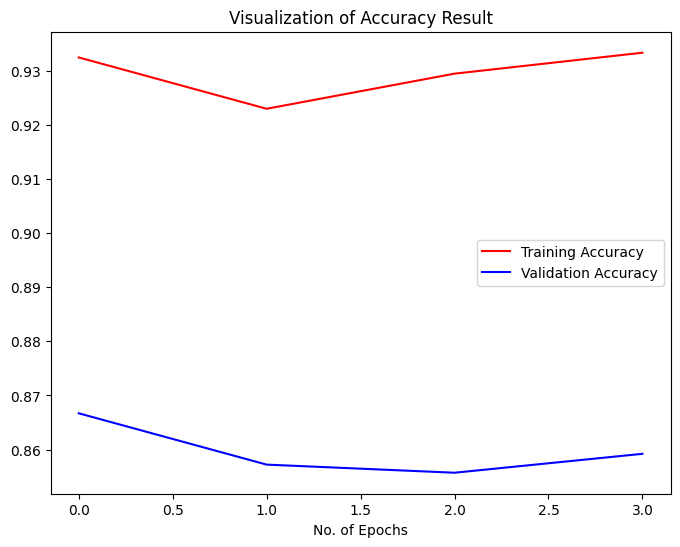

In [ ]:
# Cell 8: Train the Model

# Import the EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback with the desired accuracy threshold
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3, mode='max', min_delta=0.01, restore_best_weights=True)

# Define the TensorBoard callback
from tensorflow.keras.callbacks import TensorBoard
log_dir = "/content/drive/My Drive/MODEL_CORRECTION/logs"  # Directory to store logs
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define the callbacks list
callbacks_list = [checkpoint, reduce_lr, early_stopping, tensorboard_callback]  # Add early_stopping to the list

# Class weights for each class
class_weights = {0: 1.0,  # nv
                 1: 1.0,  # mel
                 2: 1.0,  # bkl
                 3: 1.0,  # bcc
                 4: 3.0,  # akiec
                 5: 1.0,  # vasc
                 6: 1.0}  # df

# Load the best saved weights
model.load_weights('/content/drive/My Drive/MODEL_CORRECTION/model_unquant.keras')

# Set the initial learning rate to the last value from the previous training
model.optimizer.learning_rate.assign(1e-5)  # Set the learning rate

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # You can adjust the number of epochs
    callbacks=callbacks_list,
    class_weight=class_weights,  # Include class weights
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# ---  History Plotting ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='blue')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

# --- Save Training History ---
import pickle
with open('/content/drive/My Drive/MODEL_CORRECTION/training_history.pkl', 'wb') as f:  # Updated filepath
    pickle.dump(history.history, f)

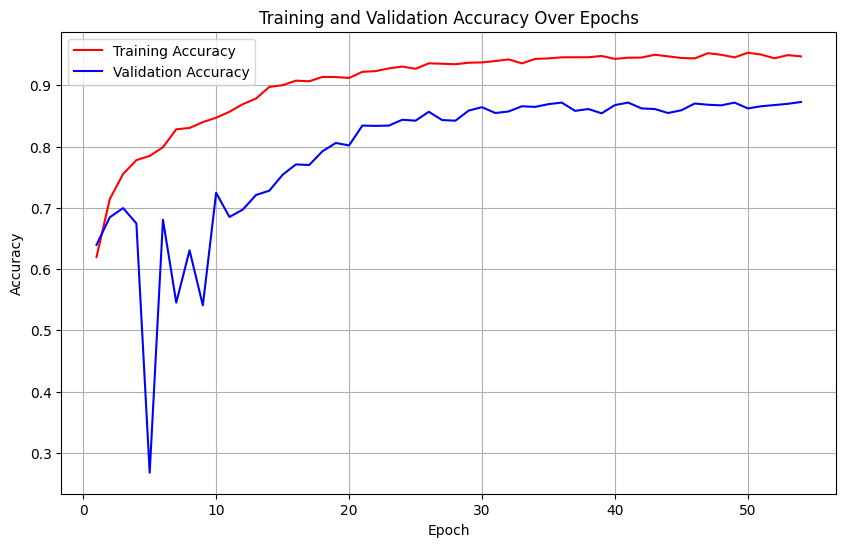

In [ ]:
import matplotlib.pyplot as plt

# Training accuracy and validation accuracy values
train_acc = [0.6196, 0.7142, 0.7552, 0.7778, 0.7846, 0.7989, 0.8281, 0.8303, 0.8399, 0.8470, 0.8567, 0.8691, 0.8783, 0.8973, 0.9001, 0.9075, 0.9065, 0.9136, 0.9134, 0.9119, 0.9219, 0.9231, 0.9276, 0.9305, 0.9269, 0.9358, 0.9351, 0.9343, 0.9368, 0.9373, 0.9395, 0.9422, 0.9357, 0.9430, 0.9438, 0.9456, 0.9457, 0.9457, 0.9478, 0.9430, 0.9450, 0.9452, 0.9498, 0.9472, 0.9445, 0.9438, 0.9523, 0.9497, 0.9455, 0.9531, 0.9501, 0.9440, 0.9492, 0.9471]
val_acc = [0.6395, 0.6845, 0.6995, 0.6745, 0.2676, 0.6805, 0.5452, 0.6306, 0.5407, 0.7244, 0.6850, 0.6970, 0.7209, 0.7279, 0.7539, 0.7708, 0.7698, 0.7923, 0.8058, 0.8018, 0.8342, 0.8337, 0.8342, 0.8437, 0.8422, 0.8567, 0.8432, 0.8422, 0.8587, 0.8642, 0.8547, 0.8572, 0.8657, 0.8647, 0.8692, 0.8717, 0.8582, 0.8612, 0.8542, 0.8677, 0.8717, 0.8622, 0.8612, 0.8547, 0.8592, 0.8702, 0.8682, 0.8672, 0.8717, 0.8622, 0.8657, 0.8677, 0.8697, 0.8727]


epochs = range(1, len(train_acc) + 1)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='red')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ---  History Plotting ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='blue')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

# --- Save Training History ---
import pickle
with open('/content/drive/My Drive/MODEL_CORRECTION/training_history.pkl', 'wb') as f:  # Updated filepath
    pickle.dump(history.history, f)

In [ ]:
# Cell 9: Evaluate the Model

# Get the true labels for the validation set
y_true = val_generator.classes

# Make predictions on the validation set
y_pred_prob = model.predict(val_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate the classification report
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

32/32 [==============================] - 35s 1s/step
              precision    recall  f1-score   support

       akiec       0.66      0.66      0.66        65
         bcc       0.84      0.72      0.77       103
         bkl       0.76      0.68      0.72       220
          df       0.74      0.74      0.74        23
         mel       0.63      0.65      0.64       223
          nv       0.92      0.94      0.93      1341
        vasc       0.96      0.82      0.88        28

    accuracy                           0.86      2003
   macro avg       0.79      0.74      0.76      2003
weighted avg       0.85      0.86      0.85      2003

Confusion Matrix:
[[  43    2   10    1    5    4    0]
 [   6   74    8    1    2   12    0]
 [  11    2  149    1   23   34    0]
 [   1    1    0   17    2    2    0]
 [   2    3   12    1  144   61    0]
 [   2    5   16    2   51 1264    1]
 [   0    1    1    0    1    2   23]]


In [ ]:
import tensorflow as tf

# Load the Keras model with safe_mode=False
model = tf.keras.models.load_model('/content/drive/MyDrive/MODEL_CORRECTION/model_unquant.keras', safe_mode=False)

# Specify a new directory for the SavedModel to avoid overwriting
saved_model_dir = '/content/drive/MyDrive/MODEL_CORRECTION/model_unquant_savedmodel'

# Save the model in the SavedModel format
model.save(saved_model_dir, save_format='tf')

print(f"SavedModel saved to: {saved_model_dir}")

In [ ]:
# Cell 10: Convert the Model to TensorFlow Lite
import tensorflow as tf

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable TensorFlow ops.
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]

tflite_model = converter.convert()

# Save the TensorFlow Lite model
tflite_model_path = '/content/drive/My Drive/MODEL_CORRECTION/model_unquant.tflite'  # Updated path
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Cell 11: Convert SavedModel to TensorFlow.js

!tensorflowjs_converter --input_format=tf_saved_model \
                       --output_node_names='dense_2' \  # Output node name from model.summary()
                       --saved_model_tags=serve \
                       /content/drive/My Drive/MODEL_CORRECTION/model_unquant \  # SavedModel directory
                       /content/drive/My Drive/MODEL_CORRECTION/tfjs_model  # Output directory for TF.js model

In [ ]:
# Cell 12: Test the TensorFlow Lite Model on Two Random Images per Class

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from collections import defaultdict

# Cell 10 (Import tflite_model_path)
tflite_model_path = '/content/drive/MyDrive/MODEL_CORRECTION/model_unquant.tflite'  # Updated path

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Group image paths by class
images_by_class = defaultdict(list)
for i, filepath in enumerate(val_generator.filepaths):
    class_index = val_generator.classes[i]
    class_name = list(train_generator.class_indices.keys())[class_index]
    images_by_class[class_name].append(filepath)

# Test on two random images per class
for class_name, image_paths in images_by_class.items():
    # Select two random images from the class
    random_image_paths = np.random.choice(image_paths, 2, replace=False)

    for random_image_path in random_image_paths:
        img = image.load_img(random_image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)

        input_data = img_array.astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)

        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Apply threshold-based prediction
        confidence = np.max(output_data)
        predicted_class_index = np.argmax(output_data)

        if confidence < 0.65:  # Threshold for "normal" skin
            predicted_class = "normal"
        else:
            predicted_class = list(train_generator.class_indices.keys())[predicted_class_index]

        print(f"Image: {random_image_path}")
        print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}")

        # Display the image with confidence in the title
        plt.figure()
        plt.imshow(img)
        plt.title(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")
        plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Cell 13: Test the Model on Random Images

import random
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import numpy as np

# Load the trained model (using the .keras model)
model = tf.keras.models.load_model('/content/drive/My Drive/MODEL_CORRECTION/model_unquant.keras')  # Updated path

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)
    return img_array

# Randomly select 2 images from each class and test the model
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

for cls in classes:
    # List images in the validation directory for the class
    img_list = os.listdir(os.path.join(val_dir, cls))
    random_images = random.sample(img_list, 2)

    for img_name in random_images:
        img_path = os.path.join(val_dir, cls, img_name)
        img_array = load_and_preprocess_image(img_path)

        # Make a prediction
        prediction = model.predict(img_array)

        # Apply threshold-based prediction
        confidence = np.max(prediction)
        predicted_class_index = np.argmax(prediction)

        if confidence < 0.65:  # Threshold for "normal" skin
            predicted_class = "normal"
        else:
            predicted_class = classes[predicted_class_index]

        # Visualize the image and prediction
        plt.imshow(image.load_img(img_path))
        plt.title(f"Predicted Class: {predicted_class}, Confidence: {confidence}")  # Include confidence in the title
        plt.show()

In [ ]:
# Cell 14: Test the TensorFlow.js Model

# This cell will contain JavaScript code, so we'll use the IPython.display module
from IPython.display import Javascript

# Function to generate JavaScript code for testing the TF.js model
def test_tfjs_model(model_path, image_path):
  js_code = f"""
  async function loadAndPredict() {{
    const model = await tf.loadLayersModel('{model_path}');
    const image = new Image();
    image.src = '{image_path}';
    await image.decode();
    const inputTensor = tf.browser.fromPixels(image)
                            .resizeNearestNeighbor([224, 224])
                            .toFloat()
                            .expandDims();
    const preprocessedInput = tf.keras.applications.mobilenet.preprocessInput(inputTensor);
    const prediction = model.predict(preprocessedInput);
    const confidence = prediction.max().dataSync()[0];
    const predictedClassIndex = prediction.argMax(1).dataSync()[0];

    const classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'];
    let predictedClass;
    if (confidence < 0.65) {{
      predictedClass = "normal";
    }} else {{
      predictedClass = classes[predictedClassIndex];
    }}

    google.colab.kernel.invokeFunction('display_prediction', [predictedClass, confidence], {{}});
  }}
  loadAndPredict();
  """
  return js_code

# Function to display the prediction in Python
from google.colab import output
output.register_callback('display_prediction', lambda predicted_class, confidence: print(f"Predicted Class: {predicted_class}, Confidence: {confidence}"))

# Randomly select 2 images from each class and test the model
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
for cls in classes:
  img_list = os.listdir(os.path.join(val_dir, cls))
  random_images = random.sample(img_list, 2)
  for img_name in random_images:
    img_path = os.path.join(val_dir, cls, img_name)
    # Convert image path to a URL that can be accessed by JavaScript
    img_url = f'file://{os.path.abspath(img_path)}'
    # Generate and execute JavaScript code
    Javascript(test_tfjs_model('/content/drive/My Drive/MODEL_CORRECTION/tfjs_model/model.json', img_url))

In [ ]:
# Cell 15: Test the SavedModel

import random
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import numpy as np

# Load the saved model
model = tf.saved_model.load('/content/drive/My Drive/MODEL_CORRECTION/model_unquant')  # Updated path

# Function to load and preprocess an image (same as before)
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)
    return img_array

# Randomly select 2 images from each class and test the model
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

for cls in classes:
    # List images in the validation directory for the class
    img_list = os.listdir(os.path.join(val_dir, cls))
    random_images = random.sample(img_list, 2)

    for img_name in random_images:
        img_path = os.path.join(val_dir, cls, img_name)
        img_array = load_and_preprocess_image(img_path)

        # Make a prediction using the SavedModel
        input_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
        predictions = model(input_tensor)  # Use the model as a function

        # Apply threshold-based prediction
        confidence = np.max(predictions)
        predicted_class_index = np.argmax(predictions)

        if confidence < 0.65:  # Threshold for "normal" skin
            predicted_class = "normal"
        else:
            predicted_class = classes[predicted_class_index]

        # Visualize the image and prediction
        plt.imshow(image.load_img(img_path))
        plt.title(f"Predicted Class: {predicted_class}, Confidence: {confidence}")  # Include confidence in the title
        plt.show()

In [ ]:
# Cell 16: Plot the Training History

# Load the training history
with open('/content/drive/My Drive/MODEL_CORRECTION/training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt

# Path to your TFLite model
model_path = '/content/drive/MyDrive/MODEL_CORRECTION/model_unquant.tflite'

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)
    return img_array, img  # Return both preprocessed array and original image

# Classes
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# Process images in the sample_data directory and its subfolders
for root, _, files in os.walk('/content/selected_images'):
    for filename in files:
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
            img_path = os.path.join(root, filename)
            img_array, original_img = load_and_preprocess_image(img_path)

            interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])

            predicted_class_index = np.argmax(output_data)
            predicted_class = classes[predicted_class_index]
            confidence = np.max(output_data)  # Get the confidence score

            # Display the image with prediction and confidence
            plt.figure()
            plt.imshow(original_img)
            plt.title(f"Predicted: {predicted_class}, Confidence: {confidence:.2f}")
            plt.axis('off')
            plt.show()

Output hidden; open in https://colab.research.google.com to view.

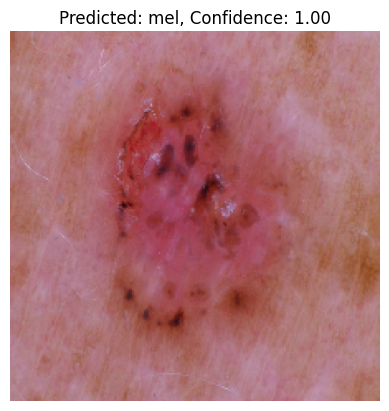

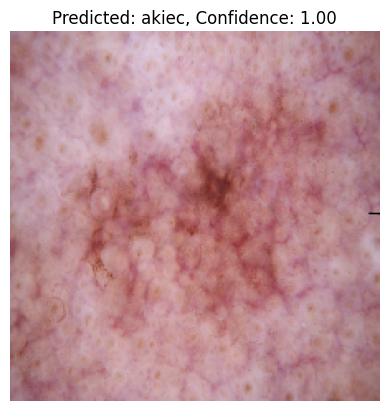

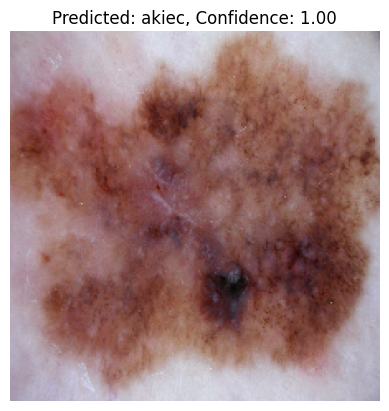

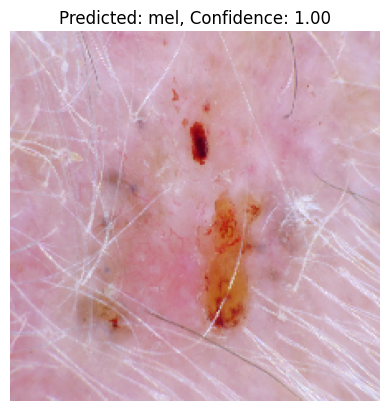

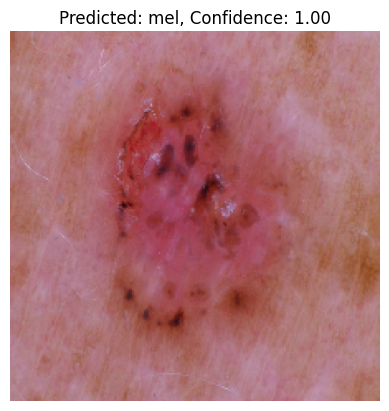

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Path to your TFLite model
model_path = '/content/drive/MyDrive/MODEL_CORRECTION/model_unquant.tflite'

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Classes
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)
    return img_array, img  # Return both preprocessed array and original image

# List of image paths to test
image_paths = [
    '/content/selected_images/mel/ISIC_0027998.jpg',
    '/content/selected_images/akiec/ISIC_0029146.jpg',
    '/content/selected_images/akiec/ISIC_0031479.jpg',
    '/content/selected_images/mel/ISIC_0024504.jpg',
    '/content/selected_images/mel/ISIC_0027998.jpg'
]

# Test each image
for img_path in image_paths:
    img_array, original_img = load_and_preprocess_image(img_path)

    interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_class_index = np.argmax(output_data)
    predicted_class = classes[predicted_class_index]
    confidence = np.max(output_data)

    # Apply confidence threshold for "normal" class
    if confidence < 0.6:
        predicted_class = "normal"
        confidence = 1.0

    # Display the image with prediction and confidence
    plt.figure()
    plt.imshow(original_img)
    plt.title(f"Predicted: {predicted_class}, Confidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()